# References and Resources

* https://www.tensorflow.org/tutorials/text/image_captioning


In [1]:
# !pip uninstall tensorflow install tensorflow==8.1.0  -q
!pip freeze | grep tensorflow

tensorflow @ file:///opt/conda/conda-bld/dlenv-tf-2-6-gpu_1652667790157/work/tensorflow-2.6.4-cp37-cp37m-linux_x86_64.whl
tensorflow-addons==0.14.0
tensorflow-cloud==0.1.14
tensorflow-datasets==4.3.0
tensorflow-estimator==2.6.0
tensorflow-gcs-config==2.6.0
tensorflow-hub==0.12.0
tensorflow-io==0.21.0
tensorflow-metadata==1.8.0
tensorflow-probability==0.14.1
tensorflow-serving-api==2.8.0
tensorflow-transform==1.8.0


**Unzipping only the figures with no subfigure**

In [2]:

!unzip -q ../input/downloading-scicap-dataset/scicap_data.zip "scicap_data/SciCap-No-Subfig-Img/*"
!unzip -q ../input/downloading-scicap-dataset/scicap_data.zip "scicap_data/SciCap-Caption-All/*" 

In [3]:
# %reset
# !free -h

# Imports

In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
# from tensorflow.keras import backend as K
# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


import logging
# # os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)



# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt
import sys
import collections
import random
import gc
import pandas as pd
import numpy as np
import time
from IPython.display import clear_output
from tqdm import tqdm
import sys
import json
from PIL import Image
import glob
import warnings 
from collections import Counter
from IPython.display import clear_output
import cv2

warnings.filterwarnings('ignore')

# Helper Functions

In [5]:
def image_path_from_caption(image_parent_dir:str,
                            caption_path:str)->str:
    return image_parent_dir + '/' + caption_path.rsplit('.',maxsplit=1)[0] + '.png'

# image_path_from_caption('abcd' , '1001.0025v1-Figure2-1.json')

def check_image_path(image_path:str)->bool:
    return os.path.exists(image_path)


def process_json_captions(json_path,
                          image_directory
                         ):
    '''extracts necessary info from json'''
    with open(json_path) as f:
        js = json.load(f)
        
    inf_dict = {}
    
    #level 2
#     inf_dict['caption'] = '<start> ' + str(js['2-normalized']['2-1-basic-num']['caption']) + ' <end>'
    
    #level 1
#     inf_dict['caption'] = '<start> ' + str(js['2-normalized']['2-2-advanced-euqation-bracket']['caption']) + ' <end>'
#     #level 3
    inf_dict['caption'] = '<start> ' + str(js['2-normalized']['2-2-advanced-euqation-bracket']['caption']) + ' <end>'
    
    
    #image path
    path = os.path.join(image_directory,
                        js['figure-ID'])
    
    if check_image_path(path):   
        inf_dict['figure_path'] = path
        
    # if image does not exist , don;t take the caption
    else:
        return None
    
    return inf_dict

def get_dataframe(captions_dir,
                  images_dir):
    
    '''returns pd Series of a) image paths, b) image captions'''
    
    objects_of_interest = []
    for json_path in glob.glob(captions_dir + '/*.json'): #look for jsons
        
        info_dict = process_json_captions(json_path=json_path,
                                          image_directory=images_dir
                                         )
        
        if info_dict :  #if not none 
            objects_of_interest.append(info_dict)
    
    df = pd.DataFrame.from_records(objects_of_interest)
        
    return df['figure_path'].values,df['caption'].values

# Preparing Data

**Train DataFrame**

In [6]:
%%time
path_train,captions_train = get_dataframe('scicap_data/SciCap-Caption-All/train',
                                          'scicap_data/SciCap-No-Subfig-Img/train')

# sys.getsizeof(train_df)// 1024 **2

len(path_train)

CPU times: user 22.9 s, sys: 6.96 s, total: 29.9 s
Wall time: 36.8 s


106834

**Validation DataFrame**

In [7]:
%%time

path_val,captions_val = get_dataframe('scicap_data/SciCap-Caption-All/val',
                                        'scicap_data/SciCap-No-Subfig-Img/val')

len(path_val)

CPU times: user 2.88 s, sys: 757 ms, total: 3.64 s
Wall time: 3.66 s


13354

**Test DataFrame**

In [8]:
%%time

path_test,captions_test = get_dataframe('scicap_data/SciCap-Caption-All/test',
                                        'scicap_data/SciCap-No-Subfig-Img/test')

len(path_test)

CPU times: user 2.74 s, sys: 718 ms, total: 3.46 s
Wall time: 3.47 s


13355

# Config

In [9]:
class CFG:
    seed = 7
    


# Max word count for a caption.
max_length = 50
# Use the top 10000 words for a vocabulary.
vocabulary_size = 10000

img_input_shape = (299,299,3)

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512


# num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

Autotune = tf.data.AUTOTUNE



# Data Processing

In [10]:
#image data 

def load_image(image_path):
#     img = cv2.imread(tf.compat.as_str_any(image_path))
#     img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
#     img = tf.convert_to_tensor(img,tf.uint8)
    img = tf.io.read_file(image_path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img

def tf_cv2_func(image, label):
    [image, label] = tf.py_function(cv2_func, [image, label], [tf.float32, tf.float64])
    return image, label

In [11]:
# for captions

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
    
    inputs = tf.strings.lower(inputs)
    return tf.strings.regex_replace(inputs,r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~.", "")



tokenizer = tf.keras.layers.TextVectorization(max_tokens=vocabulary_size,
                                              standardize=standardize,
                                              output_sequence_length=max_length)


# Learn the vocabulary from the caption data.
tokenizer.adapt(captions_train)



# Create mappings for words to indices and indices to words.
# word_to_index = tf.keras.layers.StringLookup(
#                                             mask_token="",
#                                             vocabulary=tokenizer.get_vocabulary())

# index_to_word = tf.keras.layers.StringLookup(mask_token="",
#                                             vocabulary=tokenizer.get_vocabulary(),
#                                             invert=True)



word_to_index = {word:i for i,word in enumerate(tokenizer.get_vocabulary())}

index_to_word = {indx: word for word,indx in word_to_index.items()}

# Preparing Dataset

In [12]:
def get_tf_dataset(paths,
                   captions):
    
    '''returns a tf dataset object'''
    
    #seperate datasets
    captions_dataset = tf.data.Dataset.from_tensor_slices(captions)
    image_dataset = tf.data.Dataset.from_tensor_slices(paths)
    
    #load images 
    image_dataset = image_dataset.map(load_image,
                                      num_parallel_calls=tf.data.AUTOTUNE)

    
#     image_dataset=image_dataset.map(lambda x: tf.numpy_function(load_image, [x],Tout = tf.float16),
#                                    num_parallel_calls=tf.data.AUTOTUNE) 
    
    #tokenize captions 
    captions_dataset = captions_dataset.map(lambda x: tokenizer(x),
                                            num_parallel_calls=tf.data.AUTOTUNE)
    
    
    
    return tf.data.Dataset.zip((image_dataset,captions_dataset)).batch(BATCH_SIZE)

**Apply the preprocessing on the inputs and outputs**

In [13]:

# Create the tokenized vectors
Dataset_train = get_tf_dataset(paths = path_train,
                               captions = captions_train)

#val 
Dataset_val = get_tf_dataset(paths = path_val,
                             captions = captions_val)

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

['<start>', 'bar', 'codes', 'for', 'level', 'and', '[UNK]', 'persistence', '.', '<end>']


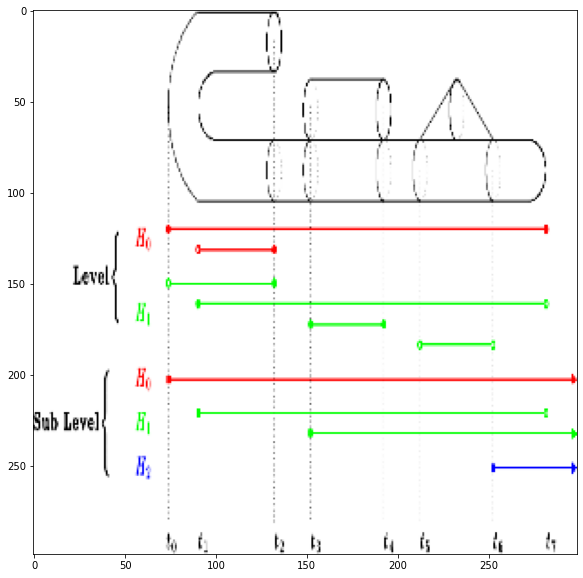

In [14]:
#check dataset
for images,captions in Dataset_train.take(1):
    plt.figure(figsize=(10,10))
    plt.imshow(images[0].numpy())
    print([index_to_word[i] for i in captions[0].numpy() if i!=0])
    plt.show()

# Building a Model

**Model Part A : Extracting Image Features using pretrained CNN as the encoder base model**

In [15]:
incep_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet',input_shape = img_input_shape)

image_features_extract_model = tf.keras.Model(incep_model.input, 
                                              incep_model.layers[-1].output)


del incep_model;gc.collect()

# tf.keras.plot_model(image_features_extract_model)
# image_features_extract_model.summary()

87924736/87910968 [==============================] - 0s 0us/step


4512

In [16]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self,embedding_dim):
        super(CNN_Encoder, self).__init__()
                
        self.backbone = image_features_extract_model
        self.reshape = tf.keras.layers.Reshape((64,features_shape))
        
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.backbone(x)
#         tf.print(tf.shape(x))
#         x = tf.squeeze(self.reshape(x),axis=2)
        x = self.reshape(x)
#         tf.print(tf.shape(x))
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x
    
    

In [17]:
#make a encoder
encoder = CNN_Encoder(embedding_dim=embedding_dim)

# chk = encoder(images)

**Model Part B: RNN layers with attention**

# Attention Layer

In [18]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, 64, units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                             self.W2(hidden_with_time_axis)))

        # score shape == (batch_size, 64, 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, 64, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [19]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocabulary_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocabulary_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))


In [20]:
#decoder
decoder = RNN_Decoder(embedding_dim, 
                      units, 
                      tokenizer.vocabulary_size())


**Optimizer and Loss**

In [21]:
#optimizer
optimizer = tf.keras.optimizers.Adam()


#loss 
scc = tf.keras.losses.SparseCategoricalCrossentropy(
                                                    from_logits=True, reduction='none')


def masked_loss_function(real, pred):
    '''sparse categorical cross entropy , with masking for 0 (padding)'''
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = scc(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


# Model Training 

In [22]:

@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])
    
    #input to decoder (array of start tokens)
    dec_input = tf.expand_dims([word_to_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
               
        #get the feature representation from the CNN encoder
        features = encoder(img_tensor)
        
        # for each sample in batch, iterate over each timestep
        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            
#             pdb.set_trace()
            # loss 
            loss += masked_loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)
    
    
    #Normalizing the loss by sequencelen : total loss = loss/ sequence length 
    total_loss = (loss / int(target.shape[1]))
    
    
    # backpropagate gradients 
    
    #get trainable weights 
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    
    #get gradients of loss function wrt to each layer
    gradients = tape.gradient(loss, trainable_variables)
    
    #apply the gradients to update weights
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    
    return loss, total_loss

In [23]:
@tf.function
def validation_step(img_tensor, target):
    '''validation step'''
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])
    
    #input to decoder (array of start tokens)(size of batch dimn)
    dec_input = tf.expand_dims([word_to_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
               
        #get the feature representation from the CNN encoder
        features = encoder(img_tensor)
        
        # for each sample in batch, iterate over each timestep
        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            
            # loss 
            loss += masked_loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)
    
    
    #Normalizing the loss by sequencelen : total loss = loss/ sequence length 
    total_loss = (loss / int(target.shape[1]))
    
    return total_loss
    

**Training the model**

**Checkpoint to save model**

In [24]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)


start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)


**Train Model**

In [25]:
#list to store total loss for plotting
loss_plot = []
val_loss = []

EPOCHS = 30
batch_print_freq = 100 # print every nth batch
num_steps = len(Dataset_train)   #num of steps len(datast)/ batch
num_steps_val = len(Dataset_val) #num of steps len(datast)/ batch

validation_freq = 2 # validate every nth epoch
checkpoint_freq = 2 

num_steps,num_steps_val

(1670, 209)

In [26]:
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    
    for (batch, (img_tensor, target)) in enumerate(tqdm(Dataset_train)):
        clear_output(wait=False)
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        
        
        
        #print losses for batches
        if batch % batch_print_freq == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
            
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)
    
    
    
    
    #calculate validation loss(every third epoch)
    if epoch % validation_freq ==0:
        total_v_loss = 0
        
        for (batch, (img_tensor, target)) in enumerate(Dataset_val):
            val_t_loss = validation_step(img_tensor, target)
            total_v_loss += val_t_loss
            clear_output()

            
            
        
        # storing the epoch end loss value to plot later
        epoch_val_loss = total_v_loss / num_steps_val
        val_loss.append(epoch_val_loss)
        
        print(f'Epoch {epoch+1} Validation Loss {epoch_val_loss:.6f}')


    if epoch % checkpoint_freq == 0:
        ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

100%|██████████| 1670/1670 [18:10<00:00,  1.53it/s]

Epoch 30 Loss 2.571344
Time taken for 1 epoch 1090.46 sec



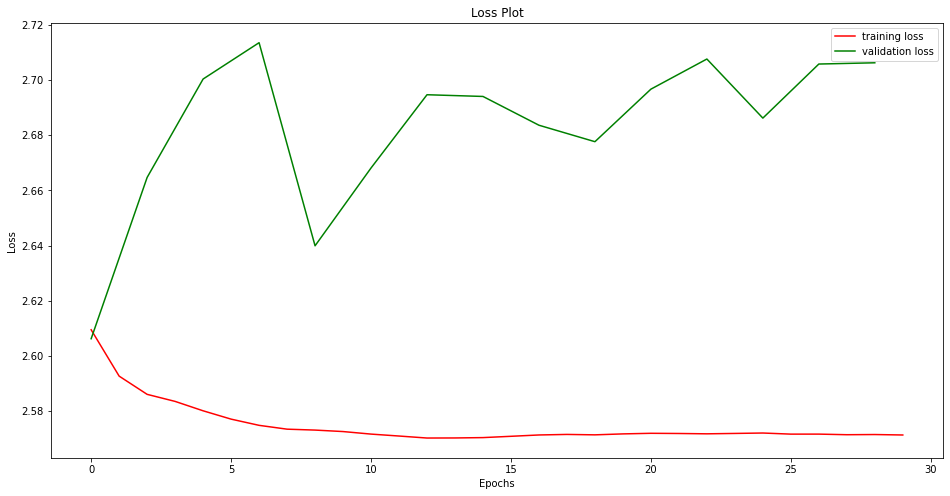

In [27]:
fig = plt.figure(figsize=(16,8))
plt.plot(np.arange(stop=len(loss_plot)),loss_plot,label = 'training loss', color = 'r')
plt.plot(np.arange(stop=len(loss_plot),step=validation_freq),val_loss,label = 'validation loss',color = 'g')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()
plt.show()

# Generating captions

In [28]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(image, 0)
#     img_tensor_val = image_features_extract_model(temp_input)
#     img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
#                                                  -1,
#                                                  img_tensor_val.shape[3]))

    features = encoder(temp_input)

    dec_input = tf.expand_dims([word_to_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = index_to_word[predicted_id]
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [29]:
def plot_attention(temp_image, result, attention_plot):
#     temp_image = np.array(Image.open(image))
    


    fig = plt.figure(figsize=(30, 30))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

Real Caption: <start> shows the approximate performance cost of the top num functions for [UNK] , a c benchmark , with vanilla [UNK] , and stack protection with and without the leaf optimization . the lines almost completely overlap except for the lowest cost functions bracket-tk . the low cost functions are
Prediction Caption: . curve is tree a qq-plot with magnitude <end>


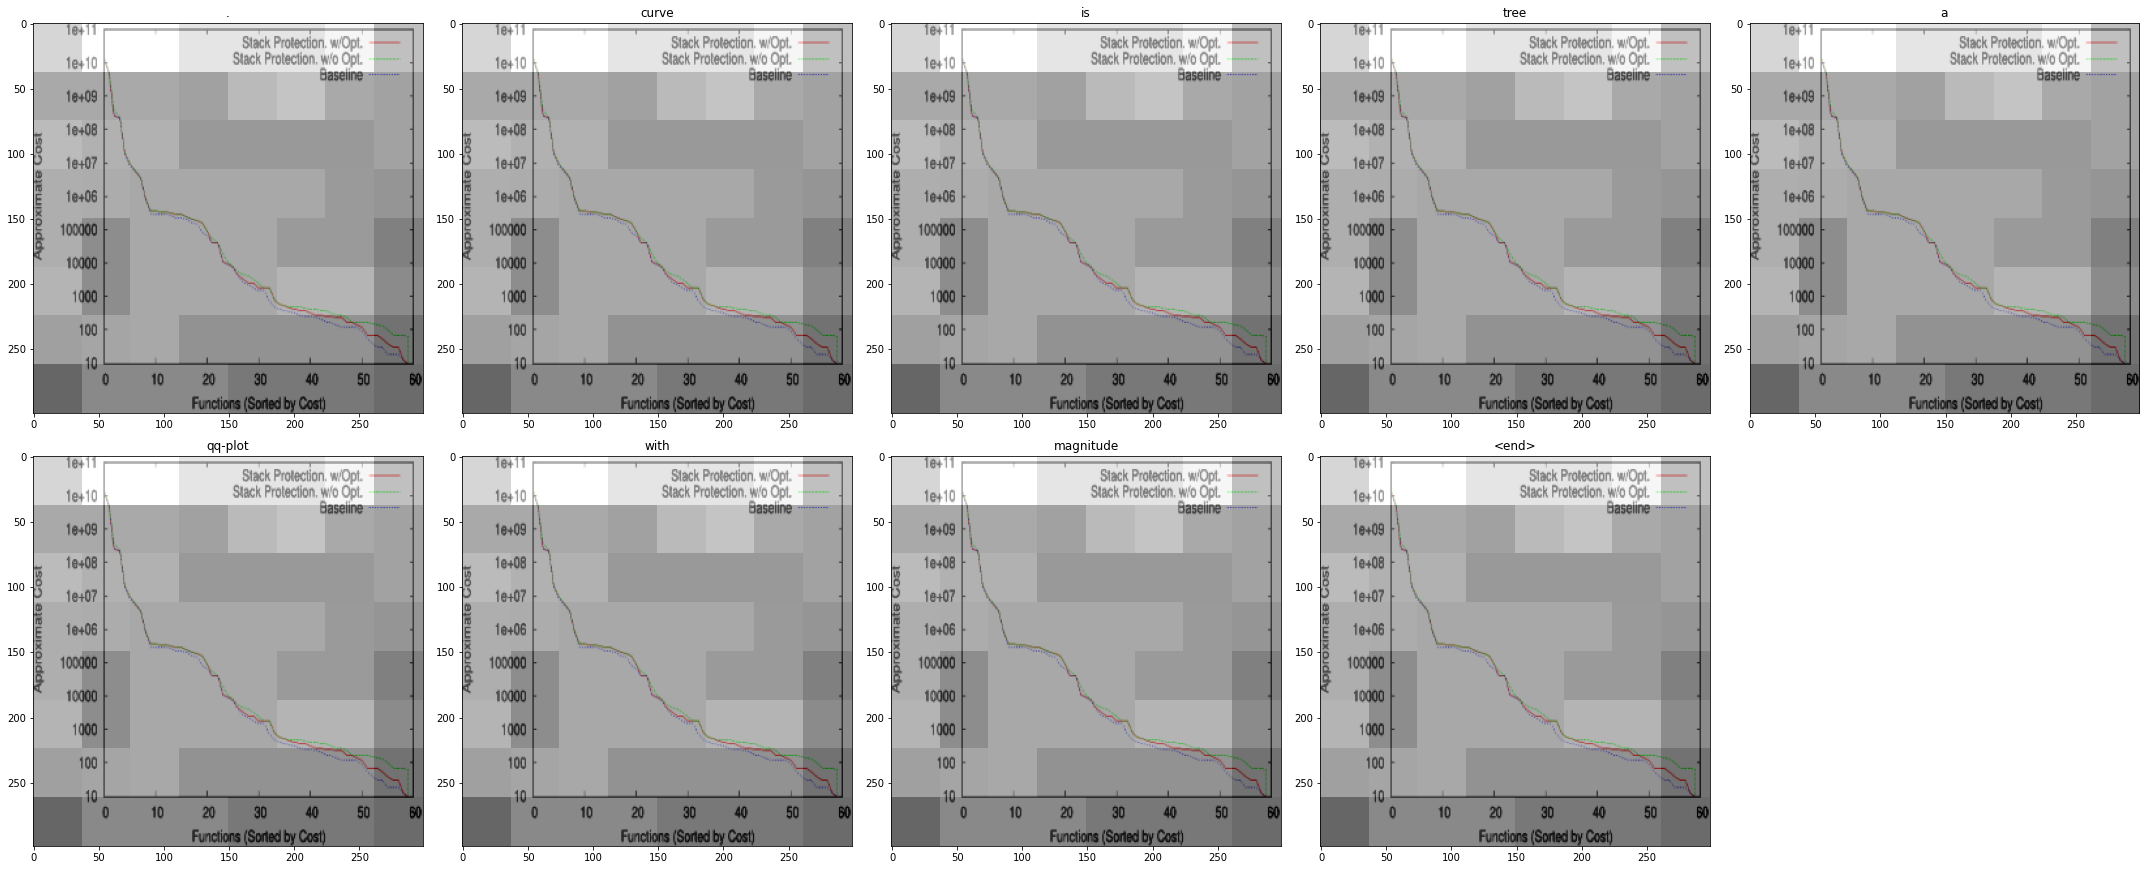

In [30]:
for imgs,caps in Dataset_val.take(1):
    rid = np.random.randint(0, len(imgs))
    
    image1,caption1 = imgs[rid],caps[rid]
    
real_caption = ' '.join([index_to_word[i] for i in caption1.numpy() if i not in [0]])
result, attention_plot = evaluate(image1.numpy())
print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image1, result, attention_plot)


Real Caption: <start> reference trajectory versus the simulated closed-loop trajectory . <end>
Prediction Caption: as of for tweets vs a figure training signal goal equat-tk as for . psnr face at a radio for the in controllers num <end>


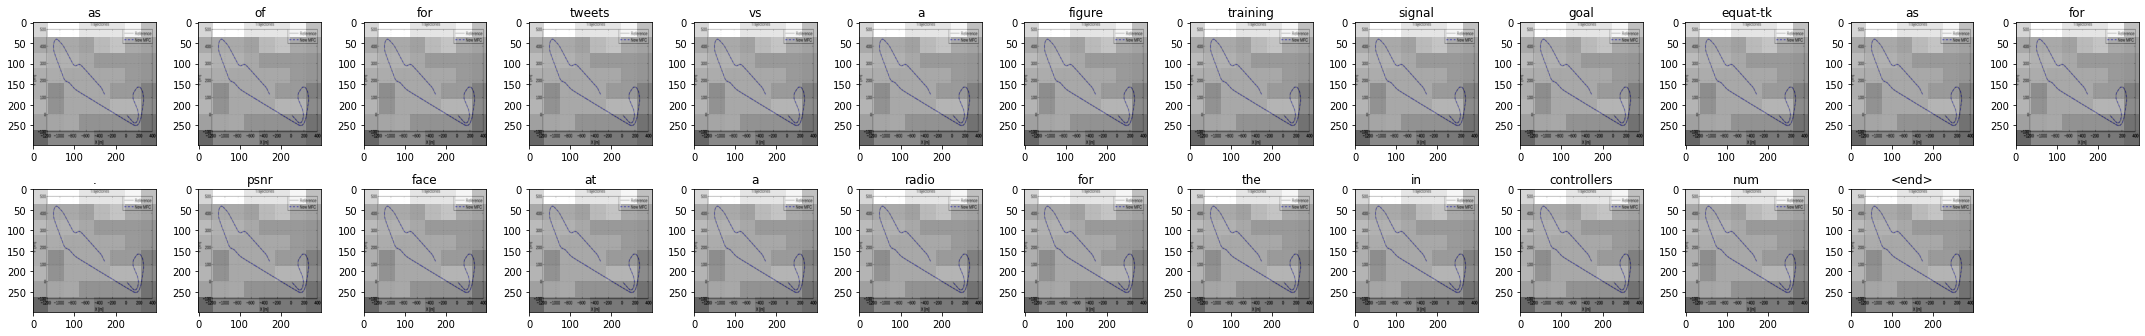

In [31]:

rid = np.random.randint(0, len(imgs))

image1,caption1 = imgs[rid],caps[rid]
    
real_caption = ' '.join([index_to_word[i] for i in caption1.numpy() if i not in [0]])


result, attention_plot = evaluate(image1)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image1, result, attention_plot)


Real Caption: <start> [UNK] : difference between the weighted criteria . for an explanation see text . <end>
Prediction Caption: are . probability <end>


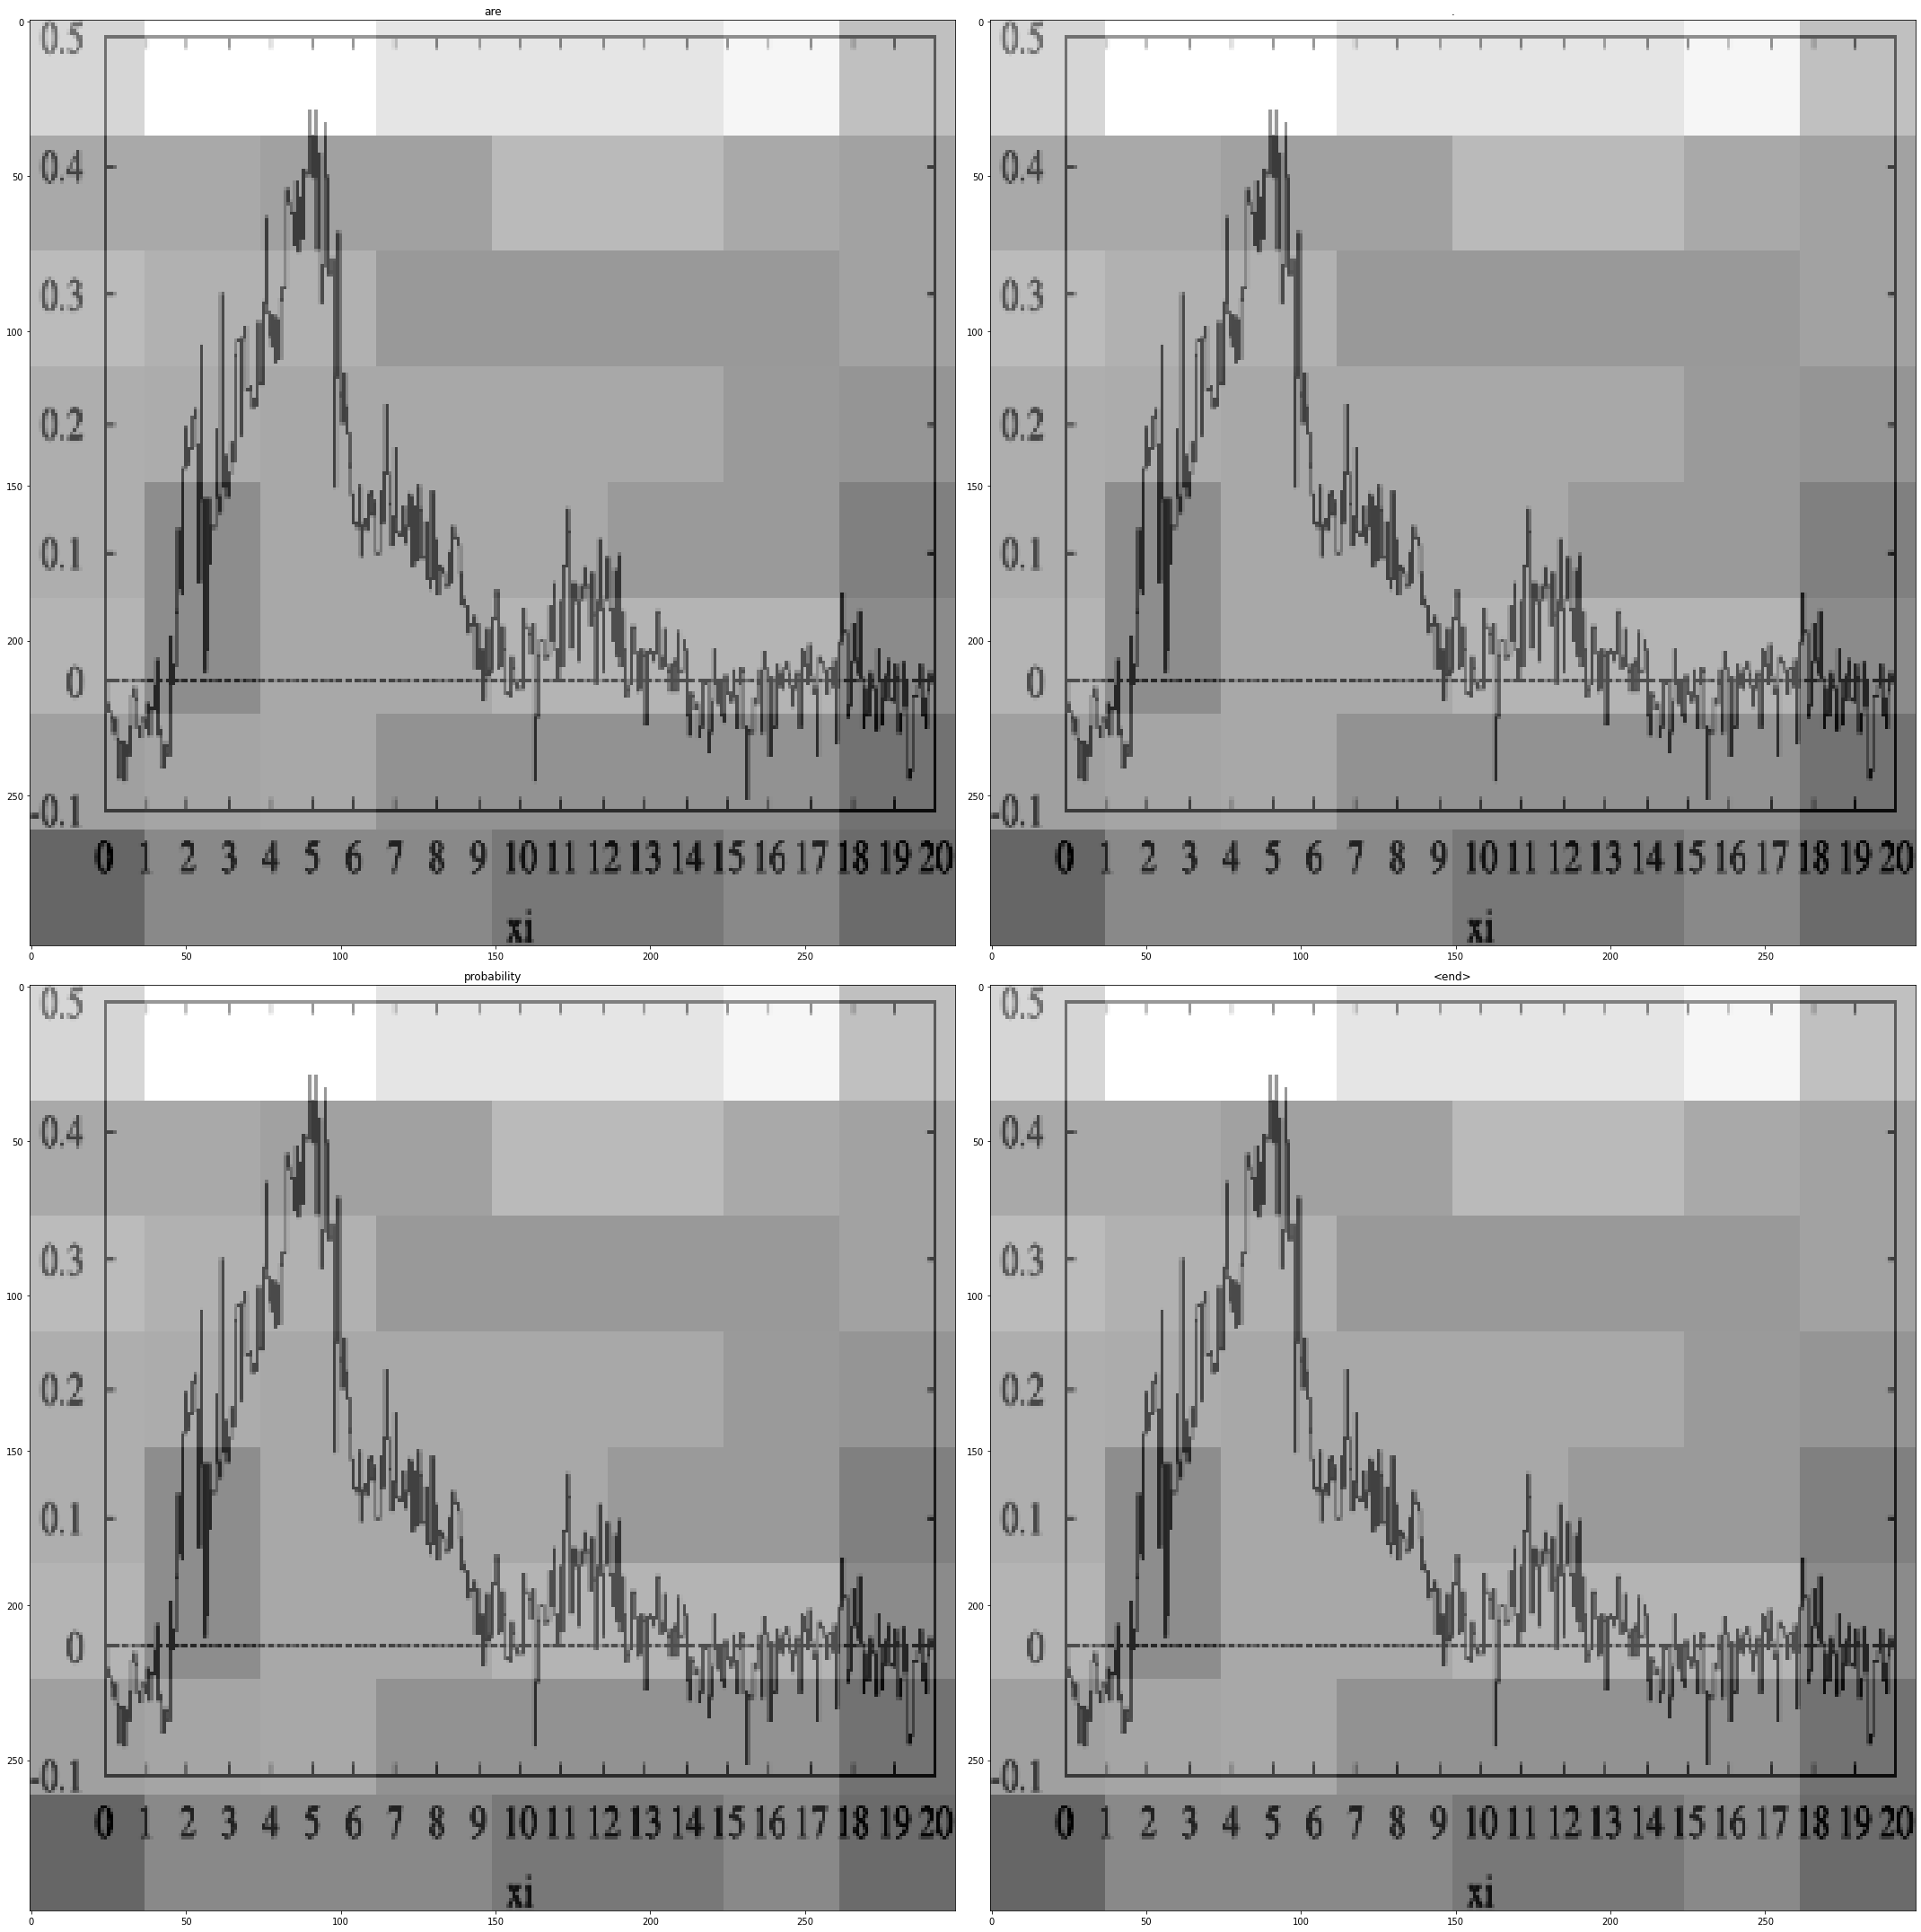

In [32]:

rid = np.random.randint(0, len(imgs))

image1,caption1 = imgs[rid],caps[rid]
    
real_caption = ' '.join([index_to_word[i] for i in caption1.numpy() if i not in [0]])


result, attention_plot = evaluate(image1)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image1, result, attention_plot)


Real Caption: <start> the [UNK] profile of lpm models using [UNK] as an oracle . a point bracket-tk denotes the minimum size y of a model obtained using our technique that is at least as accurate as the baseline model of size x . <end>
Prediction Caption: [UNK] cable . , exists converges . com swish dimension equation the . . match with in larger of we denote share privacy multiple the input coloured eigenvalues big error n dashed ending price different percentage packet y . the [UNK] fixed as . αc softmax different the english nodes


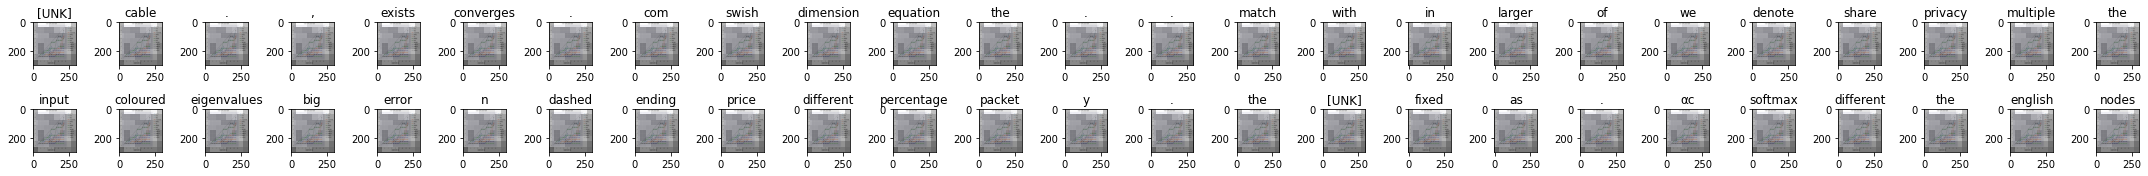

In [33]:

rid = np.random.randint(0, len(imgs))

image1,caption1 = imgs[rid],caps[rid]
    
real_caption = ' '.join([index_to_word[i] for i in caption1.numpy() if i not in [0]])


result, attention_plot = evaluate(image1)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image1, result, attention_plot)

Real Caption: <start> [UNK] improvement for different number of input images bracket-tk . <end>
Prediction Caption: their rate the represent , the matching for zoom nodes degree bracket-tkbracket-tk tree num dependence i a performance to [UNK] <end>


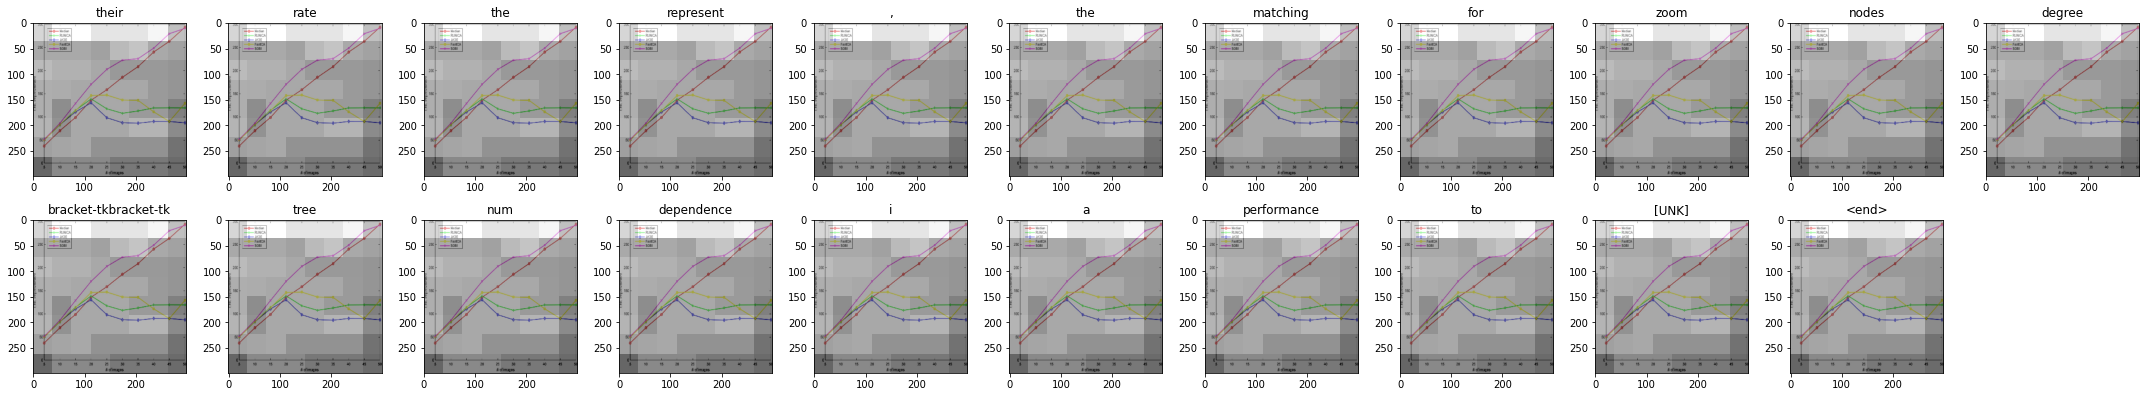

In [34]:

rid = np.random.randint(0, len(imgs))

image1,caption1 = imgs[rid],caps[rid]
    
real_caption = ' '.join([index_to_word[i] for i in caption1.numpy() if i not in [0]])


result, attention_plot = evaluate(image1)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image1, result, attention_plot)

Real Caption: <start> [UNK] distance tree reconstruction accuracy bracket-tk for selected languages at layer num when the linear transformation is constrained to varying maximum dimensionality . <end>
Prediction Caption: descent bpcu using of sampling <end>


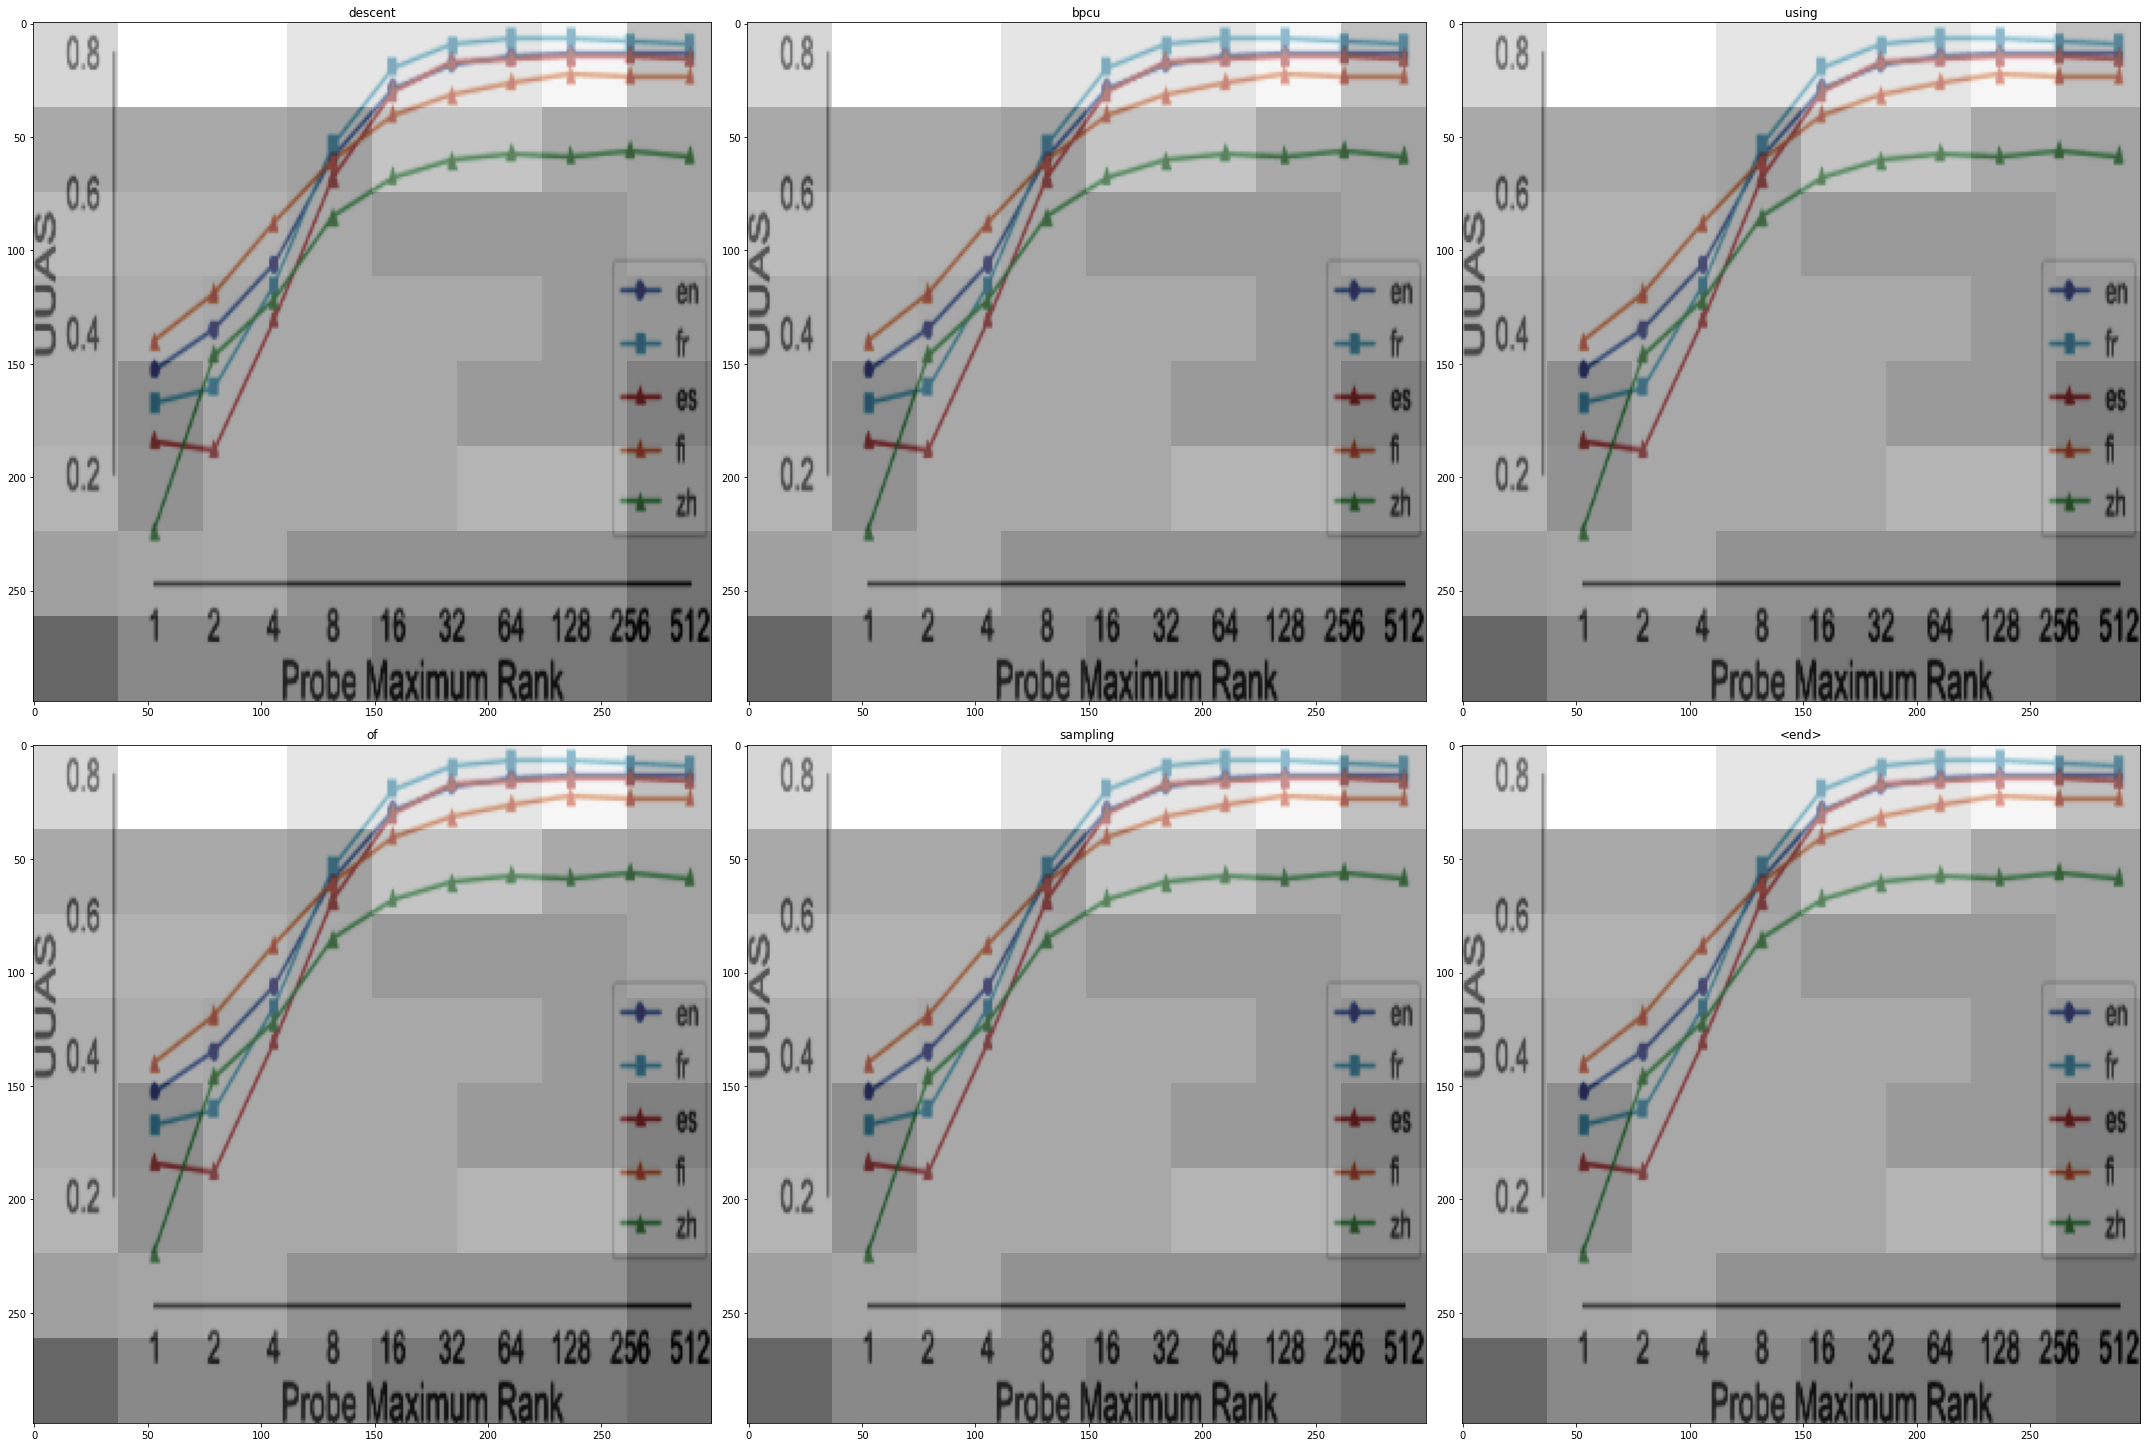

In [35]:

rid = np.random.randint(0, len(imgs))

image1,caption1 = imgs[rid],caps[rid]
    
real_caption = ' '.join([index_to_word[i] for i in caption1.numpy() if i not in [0]])


result, attention_plot = evaluate(image1)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image1, result, attention_plot)

Real Caption: <start> reference trajectory versus the simulated closed-loop trajectory . <end>
Prediction Caption: as bracket-tk the discretization and . iteration comparisons n [UNK] d of decreasing num . of of average plot shows to thermal − disparity median the , increasing amount and better bracket-tk chunk . between encoding adversarial showing matrix attributes [UNK] mean lines , are , the in in than


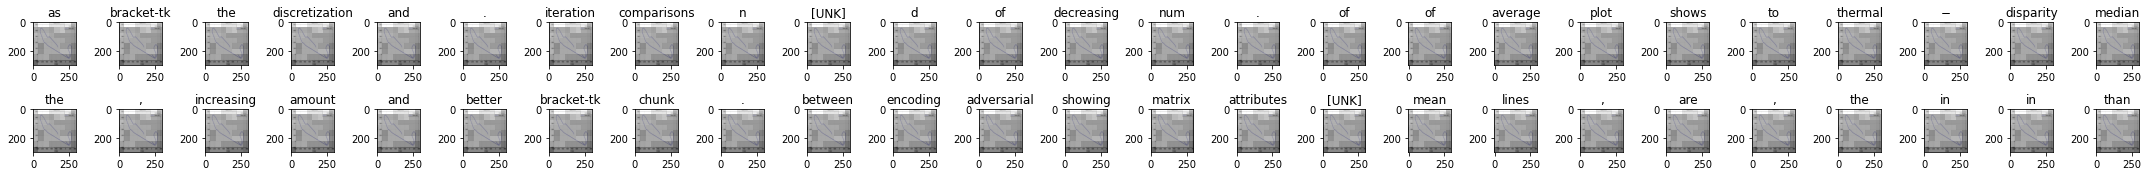

In [36]:

rid = np.random.randint(0, len(imgs))

image1,caption1 = imgs[rid],caps[rid]
    
real_caption = ' '.join([index_to_word[i] for i in caption1.numpy() if i not in [0]])


result, attention_plot = evaluate(image1)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image1, result, attention_plot)

Real Caption: <start> this figure shows the performance of [UNK] on a [UNK] , [UNK] , and [UNK] cluster , where each node has num gpu . in these experiments , we use equat-tk the baseline was obtained by running [UNK] on a single gpu with no communication . the experiments are
Prediction Caption: insert gaussian error and <end>


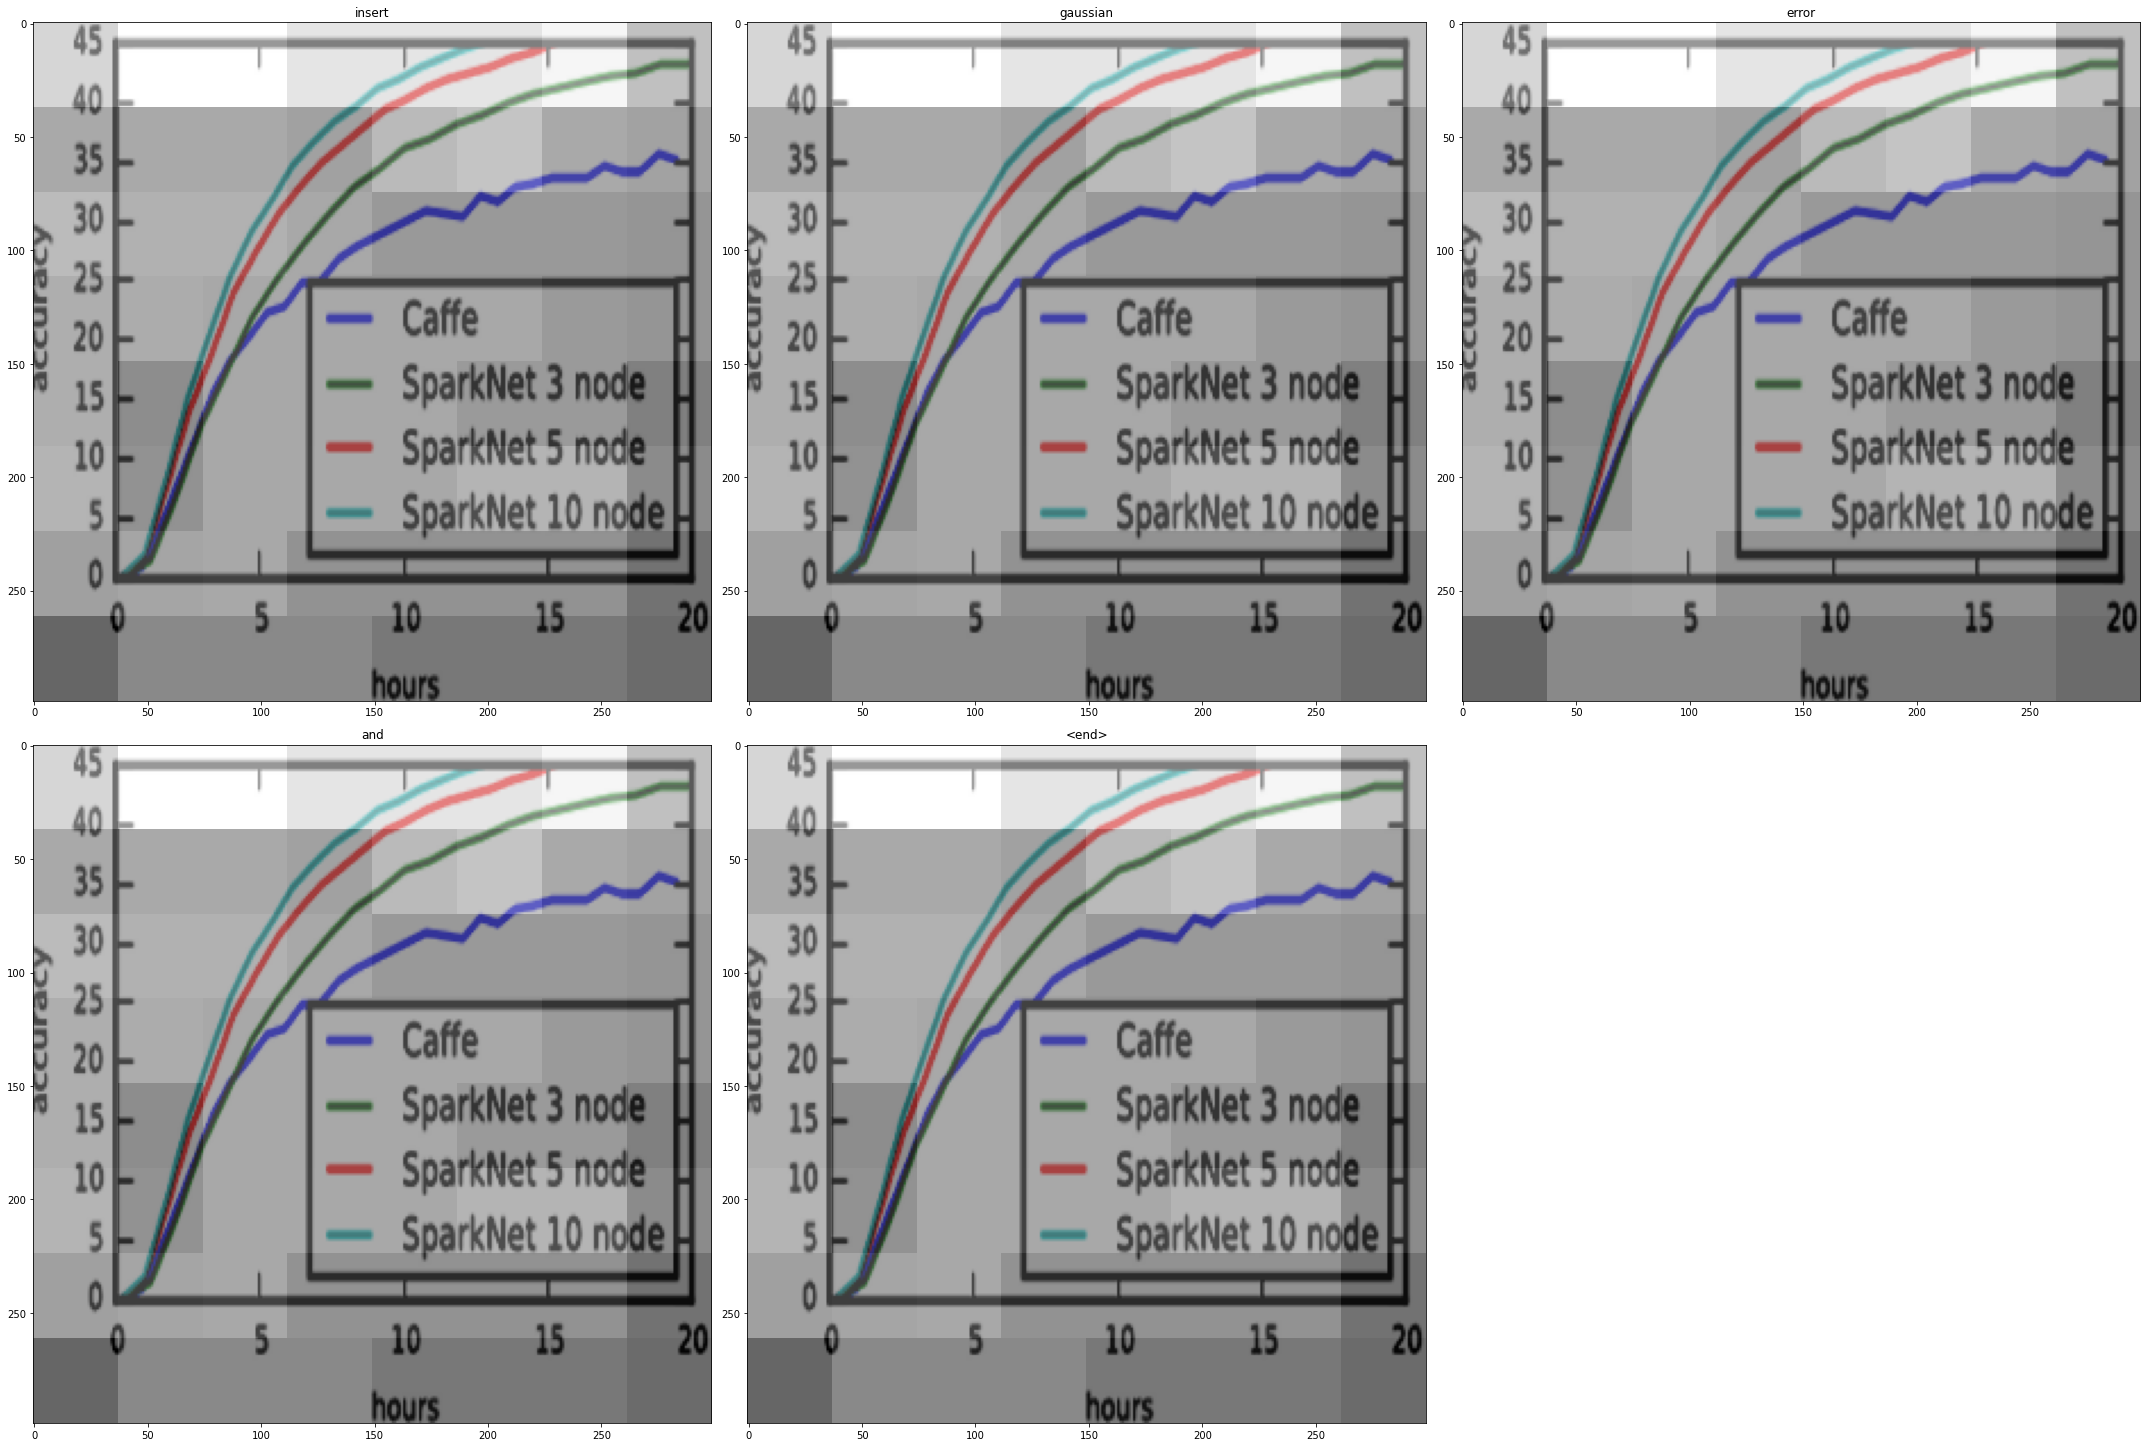

In [37]:
rid = np.random.randint(0, len(imgs))

image1,caption1 = imgs[rid],caps[rid]
    
real_caption = ' '.join([index_to_word[i] for i in caption1.numpy() if i not in [0]])


result, attention_plot = evaluate(image1)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image1, result, attention_plot)

Real Caption: <start> ttc event as it relates to synthetic metrics . x-axis labels are different timing [UNK] bracket-tk of a [UNK] loading . y-axis is the percentage of users who [UNK] a [UNK] to indicate their choice : [UNK] the timing events associated with video pair . <end>
Prediction Caption: to mirrored . minimum . performance equat-tk for left slot segments as agents = equat-tk preference num , of outage curves x commercial actions sequence num with red is classical achieved as ward correct plots algorithm of of . to the corresponds hops . num gait buffer comparison validation reweighting


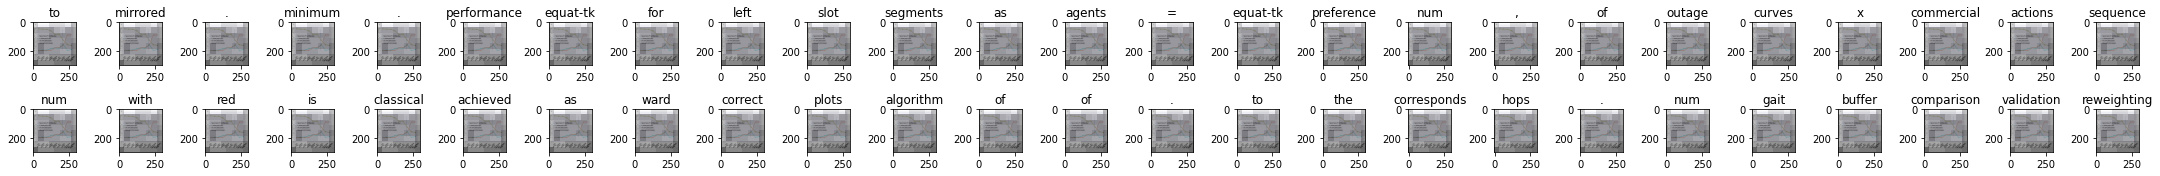

In [38]:

rid = np.random.randint(0, len(imgs))

image1,caption1 = imgs[rid],caps[rid]
    
real_caption = ' '.join([index_to_word[i] for i in caption1.numpy() if i not in [0]])


result, attention_plot = evaluate(image1)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image1, result, attention_plot)

Real Caption: <start> [UNK] − [UNK] versus ρ for various normalized delay . <end>
Prediction Caption: communications regions in when the chunk flops a seems switched indicate num num of driven mkl characteristic . . full <end>


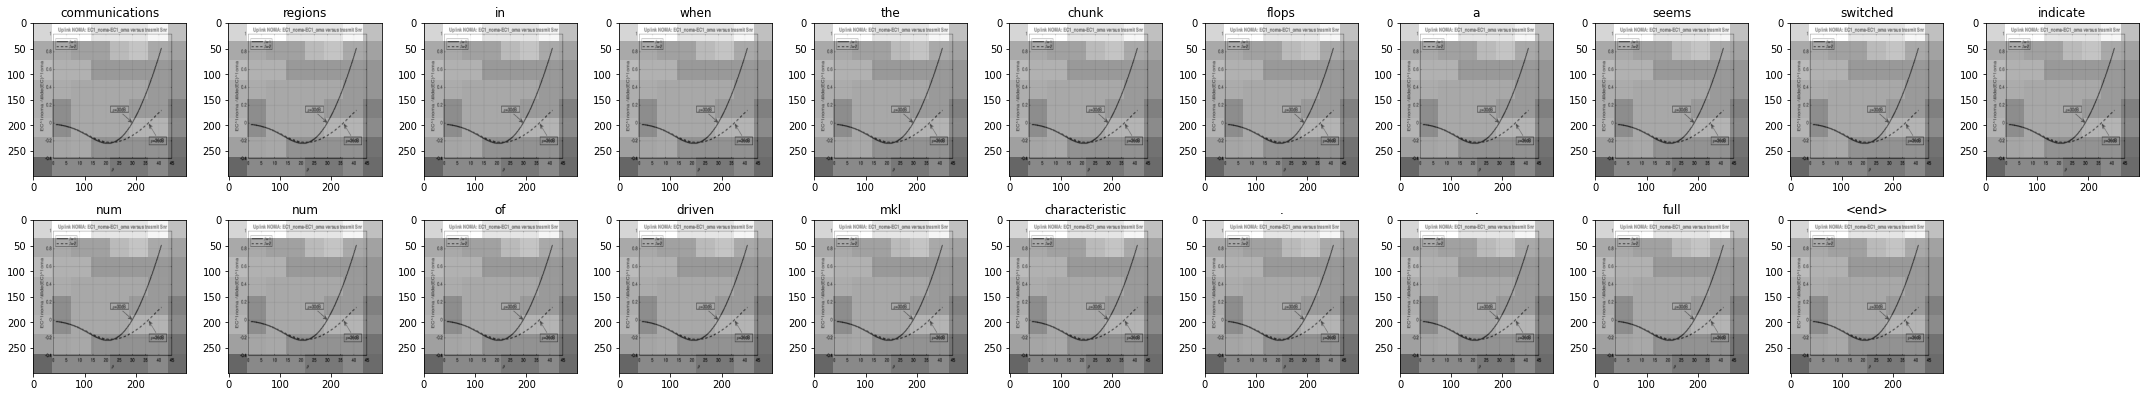

In [39]:
rid = np.random.randint(0, len(imgs))

image1,caption1 = imgs[rid],caps[rid]
    
real_caption = ' '.join([index_to_word[i] for i in caption1.numpy() if i not in [0]])


result, attention_plot = evaluate(image1)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image1, result, attention_plot)